# Biblioteki

In [1]:
from gensim.models import HdpModel
import numpy as np
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import MmCorpus
import os
import csv
import sys
import tomotopy as tp
import gensim.corpora as corpora
import pandas as pd
import matplotlib.pyplot as plt

# Ekstraktor (Sebastian)

In [2]:
from translate import Translator
import spacy
from spacy.matcher import Matcher
from collections import Counter
import PyPDF2
import re

def load_spacy_model(language_code):
    if language_code == 'en':
        return spacy.load("en_core_web_md")
    elif language_code == 'pl':
        return spacy.load("pl_core_news_md")
    elif language_code == 'es':
        return spacy.load("es_core_news_md")
    else:
        raise ValueError("Unsupported language code")

def preprocess_text(text):
    # Replace newline characters with a space
    text = text.replace('\n', ' ')

    # Remove references like [1], [2-4], [5,6], etc.
    text = re.sub(r'\[\d+–\d+\]|\[\d+(,\d+)*\]', '', text)

    # Remove any standalone numbers (e.g., dates, page numbers)
    text = re.sub(r'\b\d+\b', '', text)

    # Remove hyperlinks
    text = re.sub(r'http[s]?://\S+', '', text)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Normalize spaces to a single space
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Remove non ascii
    text = re.sub(r'[^\x00-\x7F]+', ' ', text)

    return text

def lemmatize_terms(terms, nlp):
    lemmatized_terms = {}
    for term in terms:
        doc = nlp(term)
        lemmatized_terms[term] = ' '.join([token.lemma_ for token in doc])
    return lemmatized_terms

def extract_specialist_terms(text, nlp):
    doc = nlp(text)
    specialist_terms = Counter()

    # Named Entity Recognition (NER) 
    for ent in doc.ents:
        if ent.label_ in ['ORG', 'PERSON', 'GPE', 'EVENT', 'WORK_OF_ART']:  
            term = ent.text
            specialist_terms[term] += 1
    # and Part-of-Speech (POS) Tagging
    for token in doc:
        if token.pos_ in ['NOUN']:  
            term = token.text
            specialist_terms[term] += 1
    # chunks
    for chunk in doc.noun_chunks:
            term = chunk.text
            specialist_terms[term] += 1
            
    return specialist_terms

def translate_terms(terms, target_lang):
    translator = Translator(to_lang=target_lang)
    translated_terms = {}

    for term in terms:
        translation = translator.translate(term)
        translated_terms[term] = translation

    return translated_terms

def extract_and_translate_terms(text, source_lang, target_lang):
    nlp_source = load_spacy_model(source_lang)
    
    # Extract terms in the source language
    terms = extract_specialist_terms(text, nlp_source)
    
    # Lemmatize the extracted terms using the source language model
    lemmatized_terms = lemmatize_terms(terms.keys(), nlp_source)

    # Translate lemmatized terms into the target language
    translated_terms = translate_terms(lemmatized_terms.values(), target_lang)

    return terms, translated_terms

def read_text_from_file(file_path):
    if file_path.endswith('.txt'):
        with open(file_path, 'r', encoding='utf-8') as file:
            return file.read()
    elif file_path.endswith('.pdf'):
        with open(file_path, 'rb') as file:
            pdf_reader = PyPDF2.PdfReader(file)
            text = ''
            for page_num in range(len(pdf_reader.pages)):
                text += pdf_reader.pages[page_num].extract_text()
            return text
    else:
        raise ValueError("Unsupported file format")

def extract_specialist_terms_with_patterns(text, nlp):
    
    text = preprocess_text(text)
    doc = nlp(text)
    specialist_terms = []

    # Initialize Matcher with the current spaCy model's vocabulary
    matcher = Matcher(nlp.vocab)

    # Define patterns
    patterns = [
        # Pattern 1: adjective
        [{"POS": "ADJ", "IS_PUNCT": False}],
        # Pattern 2: adjective or noun followed by noun
        [{"POS": {"IN": ["ADJ", "NOUN"]}, "OP": "*", "IS_PUNCT": False}, 
         {"POS": "NOUN"}],
        # Pattern 3: adjective or noun followed by adposition, optional determiner, adjective or noun, and noun  
        [{"POS": {"IN": ["ADJ", "NOUN"]}, "OP": "+", "IS_PUNCT": False}, 
         {"POS": "ADP", "IS_PUNCT": False},
         {"POS": "DET", "OP": "?", "IS_PUNCT": False},
         {"POS": {"IN": ["ADJ", "NOUN"]}, "OP": "*", "IS_PUNCT": False},
         {"POS": "NOUN"}],
        # Pattern 4: adjective or noun followed by zero or more adjectives, Nouns, determiners, or adpositions, and adjective or noun  
        [{"POS": {"IN": ["ADJ", "NOUN"]}, "IS_PUNCT": False},  
         {"POS": {"IN": ["ADJ", "NOUN", "DET", "ADP"]}, "OP": "*", "IS_PUNCT": False},
         {"POS": {"IN": ["ADJ", "NOUN"]}, "IS_PUNCT": False}], 
        #[{"ENT_TYPE": {"IN": ["ORG", "PERSON", "GPE", "EVENT", "WORK_OF_ART"]}}],  # Pattern 5: named entities of specified types
        #[{"ENT_TYPE": {"IN": ["ORG", "PERSON", "GPE", "EVENT", "WORK_OF_ART"]}, "OP": "+"}] # Pattern 6: named entities of specified types added together
    ]
#
    for pattern in patterns:
        matcher.add("SPECIALIST_TERM", [pattern])

    matches = matcher(doc)

    for match_id, start, end in matches:
        span = doc[start:end]
        lemmatized_term = ' '.join([token.lemma_ for token in span])
        specialist_terms.append(lemmatized_term.lower().replace(' ','_'))

    return specialist_terms

def extract_and_translate_terms_with_patterns(text, source_lang='en', target_lang='pl'):
    nlp_source = load_spacy_model(source_lang)
    
    # Extract terms using the pattern-based extractor
    terms = extract_specialist_terms_with_patterns(text, nlp_source)
    
    # Lemmatize the extracted terms using the source language model
    #lemmatized_terms = lemmatize_terms(terms, nlp_source)

    # Translate lemmatized terms into the target language
    #translated_terms = translate_terms(lemmatized_terms.values(), target_lang)

    return terms #, lemmatized_terms #, translated_terms

def post_process_terms(terms):
    #terms = [term for term in terms if 3 <= len(term.split('_')) <= 10]  # Filter by length
    terms = [term for term in terms if terms.count(term) > 1]  # Keep terms that appear more than once
    terms = [term for term in terms if not re.match(r'^\d+[a-z]*$', term)]  # Ignore terms like "d4", "400th"
    
    return terms

# Wczytanie danych

In [2]:
# słownik
id2word_path = 'data/medicine/models/medical.dict'
id2word = Dictionary.load(id2word_path)

# korpus
corpus_path = 'data/medicine/models/medical_corpus.mm'
corpus = MmCorpus(corpus_path)

In [9]:
def get_pdf_files(directory):
    all_files = os.listdir(directory)
    pdf_files = [file for file in all_files if file.endswith('.pdf')]
    return pdf_files
    
directory_path = 'data/medicine'
all_files = get_pdf_files(directory_path)
print("Number of files:", len(all_files))
print("All files:", all_files)

Number of files: 396
All files: ['-em-Leishmaniavirus--em--genetic-diversity-is-not-.pdf', '000514550.pdf', '000526024.pdf', '0069YMJ_ymj-63-305.pdf', '1-s2.0-B9780128023952000195-main.pdf', '1-s2.0-B978044464240000012X-main.pdf', '1-s2.0-S0014488614001988-main.pdf', '1-s2.0-S0014488620300455-main.pdf', '1-s2.0-S0014488622000188-main.pdf', '1-s2.0-S0014488622000942-main.pdf', '1-s2.0-S001448862200262X-main.pdf', '1-s2.0-S0014488623001176-main.pdf', '1-s2.0-S0014488624000013-main.pdf', '1-s2.0-S016517811930602X-main.pdf', '1-s2.0-S0165178119306833-main.pdf', '1-s2.0-S0165178119324308-main.pdf', '1-s2.0-S0165178120300834-main.pdf', '1-s2.0-S016517812031725X-main.pdf', '1-s2.0-S0165178122001238-main.pdf', '1-s2.0-S0925492717300835-main.pdf', '1-s2.0-S0925492721000366-main.pdf', '1-s2.0-S092549272300001X-main.pdf', '1-s2.0-S0925492723001385-main.pdf', '1-s2.0-S0925492723001774-main.pdf', '1-s2.0-S0925492724000131-main.pdf', '1-s2.0-S0932861019800890-main.pdf', '1-s2.0-S0932861019801172-mai

In [14]:
all_terms = []
for document in all_files:
    text = read_text_from_file(directory_path + "/" + document)
    extracted_terms = extract_and_translate_terms_with_patterns(text)
    terms = post_process_terms(extracted_terms)
    all_terms.append(terms)

C:\Users\Mauri\AppData\Local\Programs\Python\Python311\Lib\site-packages\PyPDF2\_cmap.py:142: PdfReadWarning: Advanced encoding /90ms-RKSJ-H not implemented yet
  warnings.warn(
C:\Users\Mauri\AppData\Local\Programs\Python\Python311\Lib\site-packages\PyPDF2\_cmap.py:142: PdfReadWarning: Advanced encoding /90ms-RKSJ-V not implemented yet
  warnings.warn(
Multiple definitions in dictionary at byte 0x27968 for key /MediaBox
Multiple definitions in dictionary at byte 0x27b48 for key /MediaBox
Multiple definitions in dictionary at byte 0x27d2f for key /MediaBox
Multiple definitions in dictionary at byte 0x27f06 for key /MediaBox
Multiple definitions in dictionary at byte 0x2811d for key /MediaBox
Multiple definitions in dictionary at byte 0x28337 for key /MediaBox
Multiple definitions in dictionary at byte 0x28536 for key /MediaBox
Multiple definitions in dictionary at byte 0x28758 for key /MediaBox
Multiple definitions in dictionary at byte 0x2894f for key /MediaBox
Multiple definitions in

In [18]:
with open('data/medicine/models/all_terms.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_terms)

In [11]:
all_terms = []
with open('data/medicine/models/all_terms.csv', 'r', newline='') as file:
    reader = csv.reader(file)
    for row in reader:
        all_terms.append(row)

# HDP - trenowanie i ewaluacja

In [3]:
def train_HDP_model(hdp, word_list, mcmc_iter, burn_in=100, quiet=False):
    '''Wrapper function to train tomotopy HDP Model object
    
    *** Inputs**
    hdp: obj -> zainicjalizowanie model HDP
    word_list: list -> lista list termów
    mcmc_iter : int -> liczba iteracji trenowania modelu
    burn_in: int -> liczba iteracji burn-in
    quiet: bool -> flaga dla dodatkowych printów
    
    ** Returns**
    hdp: wytrenowany model HDP 
    '''
    
    # dodawanie kolejnych dokumentów do trenowania
    for vec in word_list:
        hdp.add_doc(vec)

    # burn-in 
    hdp.burn_in = 100
    hdp.train(0)
    print('Num docs:', len(hdp.docs), ', Vocab size:', hdp.num_vocabs, ', Num words:', hdp.num_words)
    print('Removed top words:', hdp.removed_top_words)
    print('Training...', file=sys.stderr, flush=True)

    # trenowanie
    step=round(mcmc_iter*0.10)
    for i in range(0, mcmc_iter, step):
        hdp.train(step, workers=3)
        if not quiet:
            print('Iteration: {}\tLog-likelihood: {}\tNum. of topics: {}'.format(i, hdp.ll_per_word, hdp.live_k))
        
    print("Done\n")  
    
    return hdp

In [2]:
def get_hdp_topics(hdp, top_n=20):
    '''Ekstrakcja tematów z modelu HDP
    
    ** Inputs **
    hdp:obj -> nauczony model HDP
    top_n: int -> liczba słów najbardziej powiązanych z tematem
    
    ** Returns **
    topics: dict -> dla każdego tematu: top N słów wraz z częstotliwościami
    '''
    
    # sortowanie od najważniejszego tematu
    sorted_topics = [k for k, v in sorted(enumerate(hdp.get_count_by_topics()), key=lambda x:x[1], reverse=True)]

    topics=dict()
    
    for k in sorted_topics:
        if not hdp.is_live_topic(k): continue # usuń nieprzypisane tematy
        topic_wp =[]
        for word, prob in hdp.get_topic_words(k, top_n=top_n):
            topic_wp.append((word, prob))

        topics[k] = topic_wp
        
    return topics

In [97]:
tw_list = [tp.TermWeight.ONE, # równa waga dla wszystkich termów
           tp.TermWeight.PMI, # znajduje powiązania między termami
           tp.TermWeight.IDF] # niska waga dla częstych termów, wysoka dla rzadkich

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=1, rm_top=5, gamma=1, alpha=0.1,
                     initial_k=10, seed=42)
    
    print("Model " + tw_names[i] )
    hdp = train_HDP_model(hdp, all_terms, mcmc_iter=1000)
    hdp.save(''.join(['data/medicine/models/hdp/hdp_model_10_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Model one


C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']


C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:29: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(step, workers=3)


Iteration: 0	Log-likelihood: -8.80748171700833	Num. of topics: 11
Iteration: 100	Log-likelihood: -8.80298521774393	Num. of topics: 11
Iteration: 200	Log-likelihood: -8.796974788585203	Num. of topics: 11
Iteration: 300	Log-likelihood: -8.795805089560687	Num. of topics: 11
Iteration: 400	Log-likelihood: -8.793499736109313	Num. of topics: 11
Iteration: 500	Log-likelihood: -8.792428136297188	Num. of topics: 11
Iteration: 600	Log-likelihood: -8.792402800789338	Num. of topics: 11
Iteration: 700	Log-likelihood: -8.790355020797481	Num. of topics: 11
Iteration: 800	Log-likelihood: -8.790186153091458	Num. of topics: 11
Iteration: 900	Log-likelihood: -8.78803010834743	Num. of topics: 11
Done

Model pmi


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -8.825089625407879	Num. of topics: 14
Iteration: 100	Log-likelihood: -8.740486503028999	Num. of topics: 14
Iteration: 200	Log-likelihood: -8.678926757010771	Num. of topics: 14
Iteration: 300	Log-likelihood: -8.640848392250971	Num. of topics: 14
Iteration: 400	Log-likelihood: -8.633825562197439	Num. of topics: 14
Iteration: 500	Log-likelihood: -8.631749639610963	Num. of topics: 14
Iteration: 600	Log-likelihood: -8.635432967614568	Num. of topics: 14
Iteration: 700	Log-likelihood: -8.639396804170062	Num. of topics: 14
Iteration: 800	Log-likelihood: -8.643302955414656	Num. of topics: 14
Iteration: 900	Log-likelihood: -8.65072267349961	Num. of topics: 14
Done

Model idf


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -8.968230475926754	Num. of topics: 13
Iteration: 100	Log-likelihood: -8.928569421375165	Num. of topics: 13
Iteration: 200	Log-likelihood: -8.9114871498975	Num. of topics: 13
Iteration: 300	Log-likelihood: -8.905594444654257	Num. of topics: 13
Iteration: 400	Log-likelihood: -8.901561703613321	Num. of topics: 13
Iteration: 500	Log-likelihood: -8.896436576650252	Num. of topics: 13
Iteration: 600	Log-likelihood: -8.88886676985817	Num. of topics: 13
Iteration: 700	Log-likelihood: -8.877402609607946	Num. of topics: 13
Iteration: 800	Log-likelihood: -8.860554208539229	Num. of topics: 13
Iteration: 900	Log-likelihood: -8.8338409304838	Num. of topics: 13
Done



In [96]:
tw_list = [tp.TermWeight.ONE, # równa waga dla wszystkich termów
           tp.TermWeight.PMI, # znajduje powiązania między termami
           tp.TermWeight.IDF] # niska waga dla częstych termów, wysoka dla rzadkich

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=1, rm_top=5, gamma=1, alpha=0.1,
                     initial_k=30, seed=42)
    
    print("Model " + tw_names[i] )
    hdp = train_HDP_model(hdp, all_terms, mcmc_iter=1000)
    hdp.save(''.join(['data/medicine/models/hdp/hdp_model_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Model one


C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
Training...
C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:29: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(step, workers=3)


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -8.388943872201342	Num. of topics: 31
Iteration: 100	Log-likelihood: -8.385063117330775	Num. of topics: 31
Iteration: 200	Log-likelihood: -8.382361760869088	Num. of topics: 31
Iteration: 300	Log-likelihood: -8.377796028866163	Num. of topics: 31
Iteration: 400	Log-likelihood: -8.376647883597443	Num. of topics: 31
Iteration: 500	Log-likelihood: -8.372249837563	Num. of topics: 31
Iteration: 600	Log-likelihood: -8.37068162617056	Num. of topics: 31
Iteration: 700	Log-likelihood: -8.370753009374909	Num. of topics: 31
Iteration: 800	Log-likelihood: -8.370424683161229	Num. of topics: 31
Iteration: 900	Log-likelihood: -8.370104154666027	Num. of topics: 31
Done

Model pmi


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -8.069022441408972	Num. of topics: 31
Iteration: 100	Log-likelihood: -8.051815316067167	Num. of topics: 31
Iteration: 200	Log-likelihood: -8.046832085900926	Num. of topics: 31
Iteration: 300	Log-likelihood: -8.039975029047877	Num. of topics: 31
Iteration: 400	Log-likelihood: -8.034787909424482	Num. of topics: 31
Iteration: 500	Log-likelihood: -8.029286320883106	Num. of topics: 31
Iteration: 600	Log-likelihood: -8.02894074550136	Num. of topics: 31
Iteration: 700	Log-likelihood: -8.023704779702022	Num. of topics: 31
Iteration: 800	Log-likelihood: -8.021452028885971	Num. of topics: 31
Iteration: 900	Log-likelihood: -8.017999689801398	Num. of topics: 31
Done

Model idf


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -8.261014959489858	Num. of topics: 31
Iteration: 100	Log-likelihood: -8.247885745596998	Num. of topics: 31
Iteration: 200	Log-likelihood: -8.24294278954901	Num. of topics: 31
Iteration: 300	Log-likelihood: -8.242161052219833	Num. of topics: 31
Iteration: 400	Log-likelihood: -8.244343715270595	Num. of topics: 31
Iteration: 500	Log-likelihood: -8.247671776164017	Num. of topics: 31
Iteration: 600	Log-likelihood: -8.250540275267664	Num. of topics: 31
Iteration: 700	Log-likelihood: -8.256266009746582	Num. of topics: 31
Iteration: 800	Log-likelihood: -8.263661766936593	Num. of topics: 31
Iteration: 900	Log-likelihood: -8.27053193027243	Num. of topics: 32
Done



In [98]:
tw_list = [tp.TermWeight.ONE, # równa waga dla wszystkich termów
           tp.TermWeight.PMI, # znajduje powiązania między termami
           tp.TermWeight.IDF] # niska waga dla częstych termów, wysoka dla rzadkich

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=1, rm_top=5, gamma=1, alpha=0.1,
                     initial_k=50, seed=42)
    
    print("Model " + tw_names[i] )
    hdp = train_HDP_model(hdp, all_terms, mcmc_iter=1000)
    hdp.save(''.join(['data/medicine/models/hdp/hdp_model_50_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Model one
Num docs:

C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
Training...
C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:29: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(step, workers=3)


 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -8.181894477389095	Num. of topics: 51
Iteration: 100	Log-likelihood: -8.180460489551123	Num. of topics: 51
Iteration: 200	Log-likelihood: -8.175023632288921	Num. of topics: 51
Iteration: 300	Log-likelihood: -8.17113590734388	Num. of topics: 51
Iteration: 400	Log-likelihood: -8.169183363916238	Num. of topics: 51
Iteration: 500	Log-likelihood: -8.167763254319215	Num. of topics: 51
Iteration: 600	Log-likelihood: -8.166332332773019	Num. of topics: 51
Iteration: 700	Log-likelihood: -8.165882839296248	Num. of topics: 51
Iteration: 800	Log-likelihood: -8.165096863299127	Num. of topics: 51
Iteration: 900	Log-likelihood: -8.165694674024554	Num. of topics: 51
Done

Model pmi


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -7.582784078897059	Num. of topics: 52
Iteration: 100	Log-likelihood: -7.580230745883546	Num. of topics: 52
Iteration: 200	Log-likelihood: -7.582220528108755	Num. of topics: 52
Iteration: 300	Log-likelihood: -7.585446574682393	Num. of topics: 52
Iteration: 400	Log-likelihood: -7.590629382920252	Num. of topics: 53
Iteration: 500	Log-likelihood: -7.595591875458814	Num. of topics: 52
Iteration: 600	Log-likelihood: -7.601282509788559	Num. of topics: 52
Iteration: 700	Log-likelihood: -7.604847696005268	Num. of topics: 52
Iteration: 800	Log-likelihood: -7.608177391433057	Num. of topics: 53
Iteration: 900	Log-likelihood: -7.61161431005343	Num. of topics: 53
Done

Model idf


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -7.937320704472659	Num. of topics: 51
Iteration: 100	Log-likelihood: -7.944406572378974	Num. of topics: 51
Iteration: 200	Log-likelihood: -7.963542876075189	Num. of topics: 51
Iteration: 300	Log-likelihood: -7.98474805869546	Num. of topics: 51
Iteration: 400	Log-likelihood: -8.004147351725639	Num. of topics: 51
Iteration: 500	Log-likelihood: -8.028410294692256	Num. of topics: 51
Iteration: 600	Log-likelihood: -8.0494035651788	Num. of topics: 51
Iteration: 700	Log-likelihood: -8.06850241081129	Num. of topics: 51
Iteration: 800	Log-likelihood: -8.086245843459862	Num. of topics: 52
Iteration: 900	Log-likelihood: -8.103440182733186	Num. of topics: 51
Done



In [99]:
tw_list = [tp.TermWeight.ONE, # równa waga dla wszystkich termów
           tp.TermWeight.PMI, # znajduje powiązania między termami
           tp.TermWeight.IDF] # niska waga dla częstych termów, wysoka dla rzadkich

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=1, rm_top=5, gamma=1, alpha=0.1,
                     initial_k=100, seed=42)
    
    print("Model " + tw_names[i] )
    hdp = train_HDP_model(hdp, all_terms, mcmc_iter=1000)
    hdp.save(''.join(['data/medicine/models/hdp/hdp_model_100_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Model one


C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
Training...
C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:29: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(step, workers=3)


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -7.910681393387415	Num. of topics: 96
Iteration: 100	Log-likelihood: -7.899719915752614	Num. of topics: 96
Iteration: 200	Log-likelihood: -7.895439969234028	Num. of topics: 96
Iteration: 300	Log-likelihood: -7.896632277996826	Num. of topics: 95
Iteration: 400	Log-likelihood: -7.8957243623591475	Num. of topics: 95
Iteration: 500	Log-likelihood: -7.893924883907661	Num. of topics: 95
Iteration: 600	Log-likelihood: -7.8932740141385755	Num. of topics: 95
Iteration: 700	Log-likelihood: -7.893561724810492	Num. of topics: 95
Iteration: 800	Log-likelihood: -7.893105497183587	Num. of topics: 95
Iteration: 900	Log-likelihood: -7.893116543239605	Num. of topics: 95
Done

Model pmi


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -7.188527572356214	Num. of topics: 97
Iteration: 100	Log-likelihood: -7.1446878388650275	Num. of topics: 96
Iteration: 200	Log-likelihood: -7.148616894640325	Num. of topics: 95
Iteration: 300	Log-likelihood: -7.165228458495696	Num. of topics: 92
Iteration: 400	Log-likelihood: -7.163825685863856	Num. of topics: 92
Iteration: 500	Log-likelihood: -7.1794234611135535	Num. of topics: 92
Iteration: 600	Log-likelihood: -7.18667860936884	Num. of topics: 92
Iteration: 700	Log-likelihood: -7.189597529239575	Num. of topics: 91
Iteration: 800	Log-likelihood: -7.208577753126904	Num. of topics: 93
Iteration: 900	Log-likelihood: -7.211939436591037	Num. of topics: 90
Done

Model idf


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -7.39837023579233	Num. of topics: 100
Iteration: 100	Log-likelihood: -7.380218280116891	Num. of topics: 101
Iteration: 200	Log-likelihood: -7.3746782023907915	Num. of topics: 101
Iteration: 300	Log-likelihood: -7.37000305591871	Num. of topics: 100
Iteration: 400	Log-likelihood: -7.36812081188188	Num. of topics: 101
Iteration: 500	Log-likelihood: -7.3626672492175365	Num. of topics: 100
Iteration: 600	Log-likelihood: -7.358866538169413	Num. of topics: 102
Iteration: 700	Log-likelihood: -7.355054589820366	Num. of topics: 100
Iteration: 800	Log-likelihood: -7.351121531348339	Num. of topics: 102
Iteration: 900	Log-likelihood: -7.347413107144251	Num. of topics: 100
Done



In [100]:
tw_list = [tp.TermWeight.ONE, # równa waga dla wszystkich termów
           tp.TermWeight.PMI, # znajduje powiązania między termami
           tp.TermWeight.IDF] # niska waga dla częstych termów, wysoka dla rzadkich

tw_names = ['one', 'pmi', 'idf']
model_topics =[]

for i, term_weight in enumerate(tw_list):
    hdp = tp.HDPModel(tw=term_weight, min_cf=1, rm_top=5, gamma=1, alpha=0.1,
                     initial_k=75, seed=42)
    
    print("Model " + tw_names[i] )
    hdp = train_HDP_model(hdp, all_terms, mcmc_iter=1000)
    hdp.save(''.join(['data/medicine/models/hdp/hdp_model_75_',tw_names[i],".bin"]))
    
    model_topics.append(get_hdp_topics(hdp, top_n=10))

Model one


C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:21: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(0)
Training...
C:\Users\Mauri\AppData\Local\Temp\ipykernel_3900\2079868933.py:29: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  hdp.train(step, workers=3)


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -8.028516821507662	Num. of topics: 74
Iteration: 100	Log-likelihood: -8.015461900823983	Num. of topics: 74
Iteration: 200	Log-likelihood: -8.01327158536017	Num. of topics: 74
Iteration: 300	Log-likelihood: -8.009910154886906	Num. of topics: 74
Iteration: 400	Log-likelihood: -8.008413521355735	Num. of topics: 74
Iteration: 500	Log-likelihood: -8.003624253865263	Num. of topics: 74
Iteration: 600	Log-likelihood: -8.003201111778168	Num. of topics: 74
Iteration: 700	Log-likelihood: -8.00299052367883	Num. of topics: 74
Iteration: 800	Log-likelihood: -8.003312122885845	Num. of topics: 74
Iteration: 900	Log-likelihood: -8.002336778557494	Num. of topics: 74
Done

Model pmi


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -7.221372094894868	Num. of topics: 75
Iteration: 100	Log-likelihood: -7.226305104804329	Num. of topics: 76
Iteration: 200	Log-likelihood: -7.234460142287795	Num. of topics: 74
Iteration: 300	Log-likelihood: -7.241389983177979	Num. of topics: 75
Iteration: 400	Log-likelihood: -7.260040818490024	Num. of topics: 74
Iteration: 500	Log-likelihood: -7.263285348726747	Num. of topics: 74
Iteration: 600	Log-likelihood: -7.270442927368236	Num. of topics: 73
Iteration: 700	Log-likelihood: -7.270553537989212	Num. of topics: 73
Iteration: 800	Log-likelihood: -7.272340130628475	Num. of topics: 73
Iteration: 900	Log-likelihood: -7.274550856703339	Num. of topics: 73
Done

Model idf


Training...


Num docs: 396 , Vocab size: 68212 , Num words: 815937
Removed top words: ['patient', 'study', 'cell', 'disease', 'treatment']
Iteration: 0	Log-likelihood: -7.607445777796975	Num. of topics: 76
Iteration: 100	Log-likelihood: -7.586616005765016	Num. of topics: 77
Iteration: 200	Log-likelihood: -7.579178863489021	Num. of topics: 76
Iteration: 300	Log-likelihood: -7.577275249418483	Num. of topics: 75
Iteration: 400	Log-likelihood: -7.578263334997757	Num. of topics: 75
Iteration: 500	Log-likelihood: -7.578620254188856	Num. of topics: 75
Iteration: 600	Log-likelihood: -7.581191922360679	Num. of topics: 75
Iteration: 700	Log-likelihood: -7.586827997414772	Num. of topics: 75
Iteration: 800	Log-likelihood: -7.591813420989262	Num. of topics: 75
Iteration: 900	Log-likelihood: -7.594892953799083	Num. of topics: 76
Done



In [17]:
def eval_coherence(topics_dict, word_list, coherence_type='c_v'):
    '''Wyliczanie coherence score
    
    ** Inputs **
    topic_dict: dict -> słownik tematów
    word_list: list -> lista list termów
    coherence_typ: str -> typ wartości coherence
    
    ** Returns **
    score: float -> wartość coherence
    '''
    
    # słownik i korpus
    id2word = corpora.Dictionary(word_list)
    corpus = [id2word.doc2bow(words) for words in word_list]
    
    # lista tematów
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens=[]
        for w, p in tups:
            topic_tokens.append(w)
            
        topic_list.append(topic_tokens)
            

    # model Coherence
    print("Evaluating topic coherence...")
    cm = CoherenceModel(topics=topic_list, corpus=corpus, dictionary=id2word, texts=word_list, 
                    coherence=coherence_type)
    
    score = cm.get_coherence()
    print ("Done\n")
    return score

In [6]:
hdp_one = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_10_one.bin")
hdp_pmi = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_10_pmi.bin")
hdp_idf = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_10_idf.bin")

model_topics =[get_hdp_topics(hdp_one), 
               get_hdp_topics(hdp_pmi), 
               get_hdp_topics(hdp_idf)]

In [37]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, all_terms)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



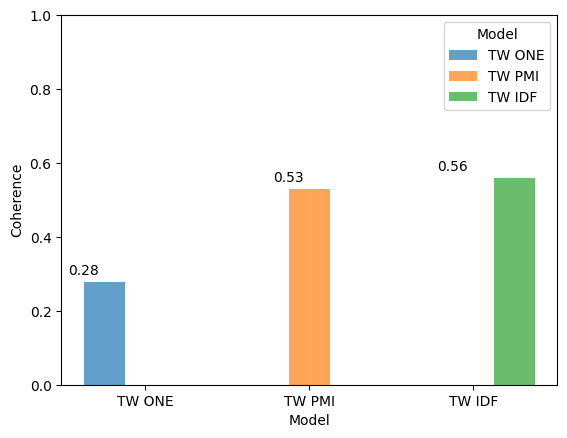

In [40]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

fig, ax = plt.subplots()

# bar plots
for i, model in enumerate(df_coherence['model'].unique()):
    subset = df_coherence[df_coherence['model'] == model]
    ax.bar(subset['index'] + 0.25*i, subset['value'], width=0.25, alpha=0.7, label=model)

# opisy
for index, row in df_coherence.iterrows():
    ax.text(row['index'] + 0.25 * (row['model'] == 'TW PMI') + 0.25 * (row['model'] == 'TW IDF') - 0.125, 
            row['value'] + 0.02, f'{row["value"]:.2f}', ha='center')

# labels
ax.set_xlabel('Model')
ax.set_ylabel('Coherence')
ax.set_xticks(df_coherence['index'] + 0.25)
ax.set_xticklabels(['TW ONE', 'TW PMI', 'TW IDF'])
ax.set_ylim(0, 1)
ax.legend(title='Model')

plt.show()

In [101]:
hdp_one_100 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_100_one.bin")
hdp_pmi_100 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_100_pmi.bin")
hdp_idf_100 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_100_idf.bin")

model_topics =[get_hdp_topics(hdp_one_100), 
               get_hdp_topics(hdp_pmi_100), 
               get_hdp_topics(hdp_idf_100)]

In [102]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, all_terms)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



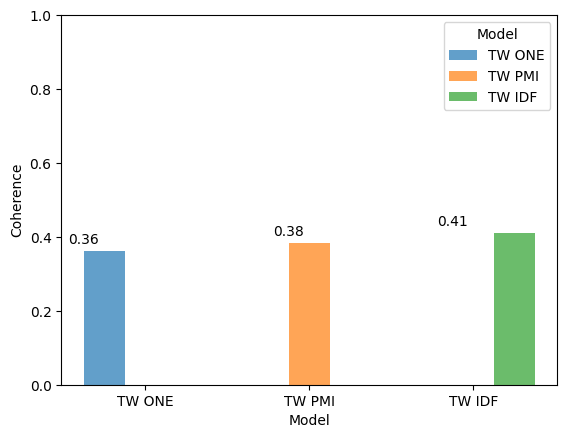

In [103]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

fig, ax = plt.subplots()

# bar plots
for i, model in enumerate(df_coherence['model'].unique()):
    subset = df_coherence[df_coherence['model'] == model]
    ax.bar(subset['index'] + 0.25*i, subset['value'], width=0.25, alpha=0.7, label=model)

# opisy
for index, row in df_coherence.iterrows():
    ax.text(row['index'] + 0.25 * (row['model'] == 'TW PMI') + 0.25 * (row['model'] == 'TW IDF') - 0.125, 
            row['value'] + 0.02, f'{row["value"]:.2f}', ha='center')

# labels
ax.set_xlabel('Model')
ax.set_ylabel('Coherence')
ax.set_xticks(df_coherence['index'] + 0.25)
ax.set_xticklabels(['TW ONE', 'TW PMI', 'TW IDF'])
ax.set_ylim(0, 1)
ax.legend(title='Model')

plt.show()

In [7]:
hdp_one_50 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_50_one.bin")
hdp_pmi_50 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_50_pmi.bin")
hdp_idf_50 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_50_idf.bin")

model_topics =[get_hdp_topics(hdp_one_50), 
               get_hdp_topics(hdp_pmi_50), 
               get_hdp_topics(hdp_idf_50)]

In [105]:
coherence_scores = np.zeros(len(model_topics))

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, all_terms)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



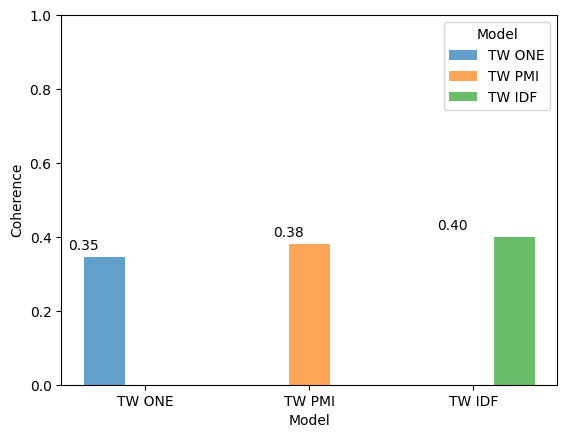

In [106]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

fig, ax = plt.subplots()

# bar plots
for i, model in enumerate(df_coherence['model'].unique()):
    subset = df_coherence[df_coherence['model'] == model]
    ax.bar(subset['index'] + 0.25*i, subset['value'], width=0.25, alpha=0.7, label=model)

# opisy
for index, row in df_coherence.iterrows():
    ax.text(row['index'] + 0.25 * (row['model'] == 'TW PMI') + 0.25 * (row['model'] == 'TW IDF') - 0.125, 
            row['value'] + 0.02, f'{row["value"]:.2f}', ha='center')

# labels
ax.set_xlabel('Model')
ax.set_ylabel('Coherence')
ax.set_xticks(df_coherence['index'] + 0.25)
ax.set_xticklabels(['TW ONE', 'TW PMI', 'TW IDF'])
ax.set_ylim(0, 1)
ax.legend(title='Model')

plt.show()

In [4]:
hdp_one_30 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_30_one.bin")
hdp_pmi_30 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_30_pmi.bin")
hdp_idf_30 = tp.HDPModel.load("data/medicine/models/hdp/hdp_model_30_idf.bin")

model_topics =[get_hdp_topics(hdp_one_30), 
               get_hdp_topics(hdp_pmi_30), 
               get_hdp_topics(hdp_idf_30)]

In [18]:
coherence_scores = np.zeros(len(model_topics))
tw_names = ['one', 'pmi', 'idf']

for i, t in enumerate(model_topics):
    print("Model " + tw_names[i] )
    coherence_scores[i] = eval_coherence(t, all_terms)

Model one
Evaluating topic coherence...
Done

Model pmi
Evaluating topic coherence...
Done

Model idf
Evaluating topic coherence...
Done



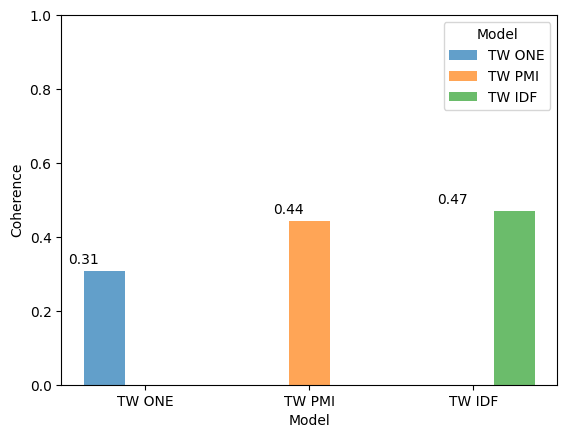

In [19]:
df_coherence = pd.DataFrame(coherence_scores).T
df_coherence.columns = ["TW ONE", "TW PMI", "TW IDF"]
df_coherence= df_coherence.melt(var_name="model").round(4)
df_coherence.reset_index(inplace=True)

fig, ax = plt.subplots()

# bar plots
for i, model in enumerate(df_coherence['model'].unique()):
    subset = df_coherence[df_coherence['model'] == model]
    ax.bar(subset['index'] + 0.25*i, subset['value'], width=0.25, alpha=0.7, label=model)

# opisy
for index, row in df_coherence.iterrows():
    ax.text(row['index'] + 0.25 * (row['model'] == 'TW PMI') + 0.25 * (row['model'] == 'TW IDF') - 0.125, 
            row['value'] + 0.02, f'{row["value"]:.2f}', ha='center')

# labels
ax.set_xlabel('Model')
ax.set_ylabel('Coherence')
ax.set_xticks(df_coherence['index'] + 0.25)
ax.set_xticklabels(['TW ONE', 'TW PMI', 'TW IDF'])
ax.set_ylim(0, 1)
ax.legend(title='Model')

plt.show()

# Wizualizacja

In [95]:
hdp_idf.summary()

<Basic Info>
| HDPModel (current version: 0.12.7)
| 396 docs, 815937 words
| Total Vocabs: 68217, Used Vocabs: 68212
| Entropy of words: 9.08332
| Entropy of term-weighted words: 10.15004
| Removed Vocabs: <NA>
|
<Training Info>
| Iterations: 1000, Burn-in steps: 100
| Optimization Interval: 10
| Log-likelihood per word: -8.77498
|
<Initial Parameters>
| tw: TermWeight.IDF
| min_cf: 1 (minimum collection frequency of words)
| min_df: 0 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| initial_k: 10 (the initial number of topics between 2 ~ 32767 The number of topics will be adjusted for data during training)
| alpha: 0.1 (concentration coeficient of Dirichlet Process for document-table )
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| gamma: 1.0 (concentration coeficient of Dirichlet Process for table-topic)
| seed: 42 (random seed)
| trained in version 0.12.7
|
<Parameters>
| alpha (concentration coefficient of Dirichle

In [51]:
import pandas as pd
import numpy as np

# Extract document-topic distributions
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in hdp_idf.docs])

# Extract topic-term distributions
topic_term_dists = np.stack([hdp.get_topic_word_dist(k) for k in range(hdp_idf.k)])

# Extract document lengths
doc_lengths = np.array([len(doc.words) for doc in hdp_idf.docs])

# Extract vocabulary and term frequency
vocab = list(hdp_idf.used_vocabs)
term_frequency = hdp_idf.used_vocab_freq

In [52]:
import pyLDAvis

data = {
    'topic_term_dists': topic_term_dists, 
    'doc_topic_dists': doc_topic_dists, 
    'doc_lengths': doc_lengths,
    'vocab': vocab,
    'term_frequency': term_frequency
}

# Convert data to the required format using PyLDAVis's functions
prepared_data = pyLDAvis.prepare(**data, mds='tsne')

In [53]:
pyLDAvis.display(prepared_data)

In [55]:
visualization_html = pyLDAvis.prepared_data_to_html(prepared_data)
html_content = f"""
<html>
<head>
<title>My HDP Visualization</title>
</head>
<body>
<h1>Topic Model Visualization</h1>
{visualization_html}
</body>
</html>
"""
with open('data/medicine/wizualizacja/hdp_model.html', 'w') as f:
    f.write(html_content)

In [22]:
import pandas as pd
import numpy as np

# Extract document-topic distributions
doc_topic_dists = np.stack([doc.get_topic_dist() for doc in hdp_idf_30.docs])

# Extract topic-term distributions
topic_term_dists = np.stack([hdp_idf_30.get_topic_word_dist(k) for k in range(hdp_idf_30.k)])

# Normalize each row to sum to 1
topic_term_dists = topic_term_dists / topic_term_dists.sum(axis=1)[:, None]

# Extract document lengths
doc_lengths = np.array([len(doc.words) for doc in hdp_idf_30.docs])

# Extract vocabulary and term frequency
vocab = list(hdp_idf_30.used_vocabs)
term_frequency = hdp_idf_30.used_vocab_freq

In [23]:
import pyLDAvis

data = {
    'topic_term_dists': topic_term_dists, 
    'doc_topic_dists': doc_topic_dists, 
    'doc_lengths': doc_lengths,
    'vocab': vocab,
    'term_frequency': term_frequency
}

# Convert data to the required format using PyLDAVis's functions
prepared_data = pyLDAvis.prepare(**data, mds='tsne')

In [24]:
pyLDAvis.display(prepared_data)

# Testowanie na nowych dokumentach

In [3]:
file_path = 'data/medicine/test/bhaskar1966.pdf'

In [4]:
text = read_text_from_file(file_path)
extracted_terms = extract_and_translate_terms_with_patterns(text)
new_terms = post_process_terms(extracted_terms)

In [5]:
new_terms

['dental',
 'oral',
 'oral_surgeryoral',
 'surgeryoral',
 'surgeryoral_pathology',
 'oral_surgeryoral_pathology',
 'pathology',
 'pathology_conference',
 'surgeryoral_pathology_conference',
 'oral_surgeryoral_pathology_conference',
 'conference',
 'many',
 'question',
 'type',
 'relative',
 'relative_incidence',
 'incidence',
 'periapical',
 'lesion',
 'number',
 'study',
 'discussion',
 'subject',
 'incidence',
 'radicular',
 'radicular_cyst',
 'cyst',
 'cent',
 'dental',
 'dental_granuloma',
 'granuloma',
 'cent',
 'cent_of_all_apical',
 'apical',
 'apical_lesion',
 'lesion',
 'fre',
 'various',
 'cent',
 'cent_of_the_lesion',
 'lesion',
 'dental',
 'dental_granuloma',
 'granuloma',
 'remainder',
 'radicular',
 'radicular_cyst',
 'cyst',
 'clinical',
 'observation',
 'cent',
 'tooth',
 'filling',
 'lesion',
 'marked',
 'size',
 'observation',
 'lesion',
 'dental',
 'dental_granuloma',
 'granuloma',
 'radicular',
 'radicular_cyst',
 'cyst',
 'addition',
 'question',
 'incidence',
 'de

In [51]:
# przygotowanie nowego dokuemntu pod inference
new_doc_insts = hdp_idf_30.make_doc(new_terms)

In [52]:
result = hdp_idf_30.infer(new_doc_insts)
print(result)

(array([9.6722710e-01, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       1.4402792e-08, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 3.2796219e-02, 0.0000000e+00, 0.0000000e+00],
      dtype=float32), -17075.17578125)


In [53]:
result[0].sum()

1.0000234

In [60]:
out = [[i, f"{(topic/result[0].sum() * 100):.1f}%"] for i, topic in enumerate(result[0]) if topic/result[0].sum() > 0.001]

In [61]:
out

[[0, '96.7%'], [29, '3.3%']]

In [65]:
hdp_idf_30.perplexity

3906.9560128722355

# Tworzenie słownika

In [35]:
import tomotopy as tp
import json
from collections import defaultdict

total_vocabulary = len(hdp_idf_30.vocabs)

# prowdopodobieństwo dla każdego słowa dla każdego z tematów
word_topic_probabilities = defaultdict(dict)
for k in range(hdp_idf_30.k):
    topic_terms = hdp_idf_30.get_topic_words(topic_id=k, top_n=total_vocabulary)
    for word, prob in topic_terms:
        word_topic_probabilities[word][k] = prob

# wybierz najbardziej prawdopodobny temat
dominant_topic_by_word = {}
threshold = 0.1  # 10%
for word, topics in word_topic_probabilities.items():
    total_sum = sum(topics.values())
    # Find indices where the condition is true
    indexes = [index for index, value in topics.items() if (value / total_sum) > 0.1]
    dominant_topic_by_word[word] = indexes

# grupowanie termów
words_by_dominant_topic = defaultdict(list)
for word, topics in dominant_topic_by_word.items():
    for topic in topics:
        words_by_dominant_topic[topic].append(word)

# tworzenia JSONa
json_data = {topic_id: {"topic": f"Topic {topic_id}", "terms": sorted(words)}
             for topic_id, words in words_by_dominant_topic.items()}

# zapis do pliku
with open('data/medicine/models/medical_dictionary_hdp.json', 'w', encoding='utf-8') as file:
    json.dump(json_data, file, indent=4, ensure_ascii=False)

print("Data saved to 'medical_dictionary_hdp.json'.")

Data saved to 'medical_dictionary_hdp.json'.
